# Final Project
## Topic: Rumor Prediction 

#### Course: Social Media Mining F19 CIS6930
#### By Anfal AlYousufi & Khaled Alshatti
#### U72884742 & U46432860


In [89]:
import re
import sys
import json
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 

#headerline
from matplotlib.legend_handler import HandlerLine2D

#SVG 
from IPython.display import SVG

#confusion matrix
from mlxtend.evaluate import confusion_matrix 
from mlxtend.plotting import plot_confusion_matrix

#nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

#sklearn
import sklearn as sk
from sklearn.svm import SVC 
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn import model_selection
from sklearn.utils import resample
from sklearn.model_selection import cross_validate
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline,make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score,make_scorer,f1_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.utils import resample

## Loading data set for tweet and tag

In [90]:
def Load_dataset(path):
    with open(path) as json_data:
        text= json.load(json_data)
    new_data = []
    for x in text:
        new_insert = {}
        for i,v in x.items():
            if not isinstance(v, dict): #true for (v,dict)
                new_insert[i] = v # not dictionary 
            else:
                 for e,f in v.items():# flatten v
                    new_insert[e] = f
        new_data.append(new_insert)
    return pd.DataFrame(new_data)

path = 'Dataset.json'
tweet = Load_dataset(path)

# Clean Data: Preprocessing

In [91]:
def process_tweet(tweet):
    
    tweet = tweet.lstrip(' ') #remove space beginning of tweet
    tweet = tweet.lower()#put all lowercase
    tweet = re.sub(r'\&\w*;', '', tweet)#remove HTML entities
    tweet = re.sub(r'#\w*', '', tweet)#remove hashtag
    tweet = re.sub(r'https?:\/\/.*\/\w*', '', tweet)#remove hyperlink
    tweet = re.sub("[^a-zA-Z]"," ",tweet)
    tweet = re.sub(r'\s\s+', ' ', tweet)#remove newline & whitespace
    tweet = re.sub(r'\b\w{1,2}\b', '', tweet) #remove words with 2< letters
    
    return tweet

tweet['strong_pro1'] = tweet['text'].apply(process_tweet)
tweet.head(n=254)

,tag,text,strong_pro1
0,real,Exclusive: Aramco agrees on price for Sabic ac...,exclusive aramco agrees price for sabic acqui...
1,real,#Digitisation contract signed in #SaudiArabia ...,contract signed for two holy mosques
2,fake,The #Taliban will not attend planned peace tal...,the will not attend planned peace talks with t...
3,real,#Qatar have used #Khashoggi to write all of th...,have used write all the articles beside us...
4,real,#Saudi sets clear rules and regulations to pro...,sets clear rules and regulations protect wil...
5,real,#Saudi ministry of justice works on developing...,ministry justice works developing commercia...
6,fake,#فتاه_تايلند\nA #Saudi woman who’s trying to f...,woman who trying flee into asylum being h...
7,real,#Saudi woman detained in #Thailand seeks asylu...,woman detained seeks asylum she sought asyl...
8,real,Saudi Government paid SR 6million blood money...,saudi government paid million blood money re...
9,fake,Gunfire Heard At Saudi Royal Palace In Riyadh ...,gunfire heard saudi royal palace riyadh rum...


### Snowball Stemmer

In [92]:
p = SnowballStemmer("english")
tweet['Stemming'] = tweet['strong_pro1'].apply(lambda x: ' '.join([p.stem(word) for word in x.split() ]))

tweet.head()

,tag,text,strong_pro1,Stemming
0,real,Exclusive: Aramco agrees on price for Sabic ac...,exclusive aramco agrees price for sabic acqui...,exclus aramco agre price for sabic acquisit
1,real,#Digitisation contract signed in #SaudiArabia ...,contract signed for two holy mosques,contract sign for two holi mosqu
2,fake,The #Taliban will not attend planned peace tal...,the will not attend planned peace talks with t...,the will not attend plan peac talk with the ar...
3,real,#Qatar have used #Khashoggi to write all of th...,have used write all the articles beside us...,have use write all the articl besid use him fo...
4,real,#Saudi sets clear rules and regulations to pro...,sets clear rules and regulations protect wil...,set clear rule and regul protect wildlif the k...


### Building countplot graph to show real from fake

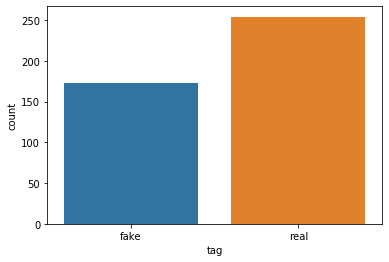

In [93]:
s = tweet.copy()
df_minority = s[s.tag == "real"] #true 
df_majority = s[s.tag == "fake"] #rumor

df_minority = resample(df_minority, 
                       replace=True,  #sample with replacement 
                       n_samples=254, #to match majority class 
                       random_state=123 #reproducible results
                      )

df_balanced = pd.concat([df_majority, df_minority])
sns.countplot(df_balanced['tag'], label="count")

plt.show()

# Pipeline : 

### 2 experiments with pipeline

#### 1: BoW(CountVectorizer()) + Classifier
#### 2: Tf-Idf (TfidfVectorizer( )) + Classifier

### 4 classifiers used
#### 1: K-NN classifier
#### 2: Multinomial NB classifier
#### 3: Suppoer Vector Matrix classifier 
#### 4: Decesion Tree classifier

### 4 experiment per classifier

#### I    BoW  + Preprocessed text 
#### II   BoW  + Preprocessed text + Stemming 
#### III  Tf-Idf + Preprocessed text 
#### IV  Tf-Idf + Preprocessed text + Stemming

# Kneighbors Classifier

### Exp1: Bow + Preprocessed text

Pipeline(memory=None,
         steps=[('vectorizer',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words='english', strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('classifier',
                 KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                      metric='minkowski', metric_params=None,
                                      n_jobs=None, n_neighbors=1, p=2,
                                      weights='uniform'))],
         verbo

[Text(0, 0.5, 'real'), Text(0, 1.5, 'fake')]

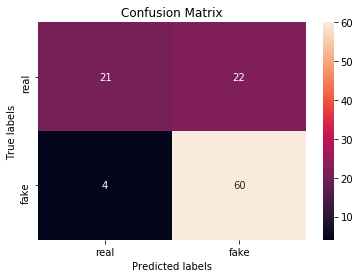

In [94]:
x=df_balanced["strong_pro1"]
y=df_balanced['tag']
tags = []
for tag in y:
    if tag == 'real':
        tags.append(1)
    if tag == 'fake':
        tags.append(0)
y = tags
#print ("tags in binary:", y)

X_train, X_test, Y_train, Y_test = model_selection.train_test_split( x, y, stratify=y, random_state=42,test_size=0.25)

pipeline = Pipeline([
    ('vectorizer',CountVectorizer(stop_words='english')),
    ('classifier', KNeighborsClassifier())])

grid = {
    'vectorizer__ngram_range': [(1, 1), (1, 2)],
    'classifier__n_neighbors':range(1,30)
}

grid_search = GridSearchCV(pipeline, param_grid=grid, scoring='accuracy', n_jobs=-1, cv=5)
grid_search.fit(X_train,Y_train)

print(grid_search.best_estimator_,"\n")

best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(list(grid.keys())):
    print("\t{0}: {1}".format(param_name, best_parameters[param_name]))

best_model = grid_search.best_estimator_
y_pred=best_model.predict(X_test)

#Confusion Matric
confusion=confusion_matrix(Y_test, y_pred)
report=classification_report(Y_test,y_pred)
false_positive_rate, true_positive_rate, thresholds = sk.metrics.roc_curve(Y_test, y_pred)
roc_auc = sk.metrics.auc(false_positive_rate, true_positive_rate)
print("Confusion matrix \n",confusion,"\n")
print("Classification_report \n ",report,"\n")
print("Train Accuracy",accuracy_score(Y_train, best_model.predict(X_train)))
print("Test Accuracy:",accuracy_score(Y_test,y_pred))
print("roc_auc_score",roc_auc)

#Plot Confusion Matrix plot
ax= plt.subplot()
sns.heatmap(confusion, annot=True, ax = ax)

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix') 
ax.xaxis.set_ticklabels(['real', 'fake'])
ax.yaxis.set_ticklabels(['real', 'fake'])

0.7289719626168224
0.719626168224299
0.7009345794392523
0.6728971962616822
0.6915887850467289
0.6915887850467289
0.6728971962616822
0.6915887850467289
0.6728971962616822
0.6728971962616822
0.6448598130841121
0.6448598130841121
0.6448598130841121
0.6448598130841121
0.6261682242990654
0.6355140186915887
0.616822429906542
0.616822429906542
0.6074766355140186
0.6074766355140186
0.6074766355140186
0.6074766355140186
0.6074766355140186
0.6074766355140186
0.5981308411214953
0.5981308411214953
0.5981308411214953
0.5981308411214953
0.5981308411214953


Text(0, 0.5, 'cross-valdition Accuracy')

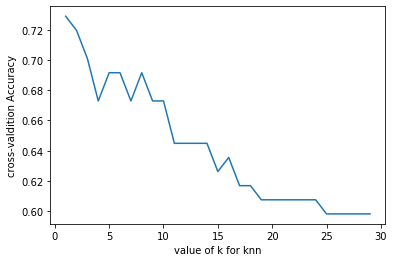

In [95]:
#Highest accuracy by gridSearchCv
K_rang=range(1,30)
K_score=[]
for k in K_rang:
    pipelineTf_Idf = Pipeline([
    ('vectorizer',CountVectorizer(stop_words='english',analyzer='word',ngram_range=(1, 2))),
    ('classifier', KNeighborsClassifier(k))])
    
    model=pipelineTf_Idf.fit(X_train,Y_train)
    y_pred = model.predict(X_test)

    K_score.append(accuracy_score(Y_test, y_pred))
for i in K_score:
    print(i)
    
#Plot KNN
plt.plot(K_rang,K_score)
plt.xlabel("value of k for knn")
plt.ylabel("cross-valdition Accuracy")

### Exp2: Bow + Preprocessed text +Stemming


Pipeline(memory=None,
         steps=[('vectorizer',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words='english', strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('classifier',
                 KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                      metric='minkowski', metric_params=None,
                                      n_jobs=None, n_neighbors=1, p=2,
                                      weights='uniform'))],
         verbo

[Text(0, 0.5, 'real'), Text(0, 1.5, 'fake')]

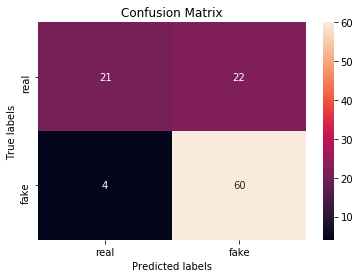

In [96]:
x=df_balanced["Stemming"]
y=df_balanced['tag']

tags = []
for tag in y:
    if tag == 'real':
        tags.append(1)
    if tag == 'fake':
        tags.append(0)
y = tags
#print ("tags in binary:", y)

X_train, X_test, Y_train, Y_test = model_selection.train_test_split( x, y, stratify=y, random_state=42,test_size=0.25)

pipeline = Pipeline([
    ('vectorizer',CountVectorizer(stop_words='english')),
    ('classifier', KNeighborsClassifier())])

grid = {
    'vectorizer__ngram_range': [(1, 1), (1, 2)],
    'classifier__n_neighbors':range(1,30)
}

grid_search = GridSearchCV(pipeline, param_grid=grid, scoring='accuracy', n_jobs=-1, cv=5)
grid_search.fit(X_train,Y_train)

print(grid_search.best_estimator_,"\n")

best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(list(grid.keys())):
    print("\t{0}: {1}".format(param_name, best_parameters[param_name]))

best_model = grid_search.best_estimator_
y_pred=best_model.predict(X_test)

#confusion Matrix
confusion=confusion_matrix(Y_test, y_pred)
report=classification_report(Y_test,y_pred)
false_positive_rate, true_positive_rate, thresholds = sk.metrics.roc_curve(Y_test, y_pred)
roc_auc = sk.metrics.auc(false_positive_rate, true_positive_rate)
print("Confusion matrix \n",confusion,"\n")
print("Classification_report \n ",report,"\n")

print("Train Accuracy",accuracy_score(Y_train, best_model.predict(X_train)))
print("Test Accuracy:",accuracy_score(Y_test,y_pred))
print("roc_auc_score",roc_auc)

#confusion matrix plot
ax= plt.subplot()
sns.heatmap(confusion, annot=True, ax = ax)

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix') 
ax.xaxis.set_ticklabels(['real', 'fake']) 
ax.yaxis.set_ticklabels(['real', 'fake'])

0.719626168224299
0.719626168224299
0.7102803738317757
0.6915887850467289
0.6822429906542056
0.6822429906542056
0.6728971962616822
0.6915887850467289
0.6728971962616822
0.6728971962616822
0.6728971962616822
0.6728971962616822
0.6542056074766355
0.6728971962616822
0.6448598130841121
0.6448598130841121
0.6448598130841121
0.6448598130841121
0.616822429906542
0.6355140186915887
0.6074766355140186
0.6261682242990654
0.6074766355140186
0.6074766355140186
0.6074766355140186
0.6074766355140186
0.5981308411214953
0.5981308411214953
0.5981308411214953


Text(0, 0.5, 'cross-valdition Accuracy')

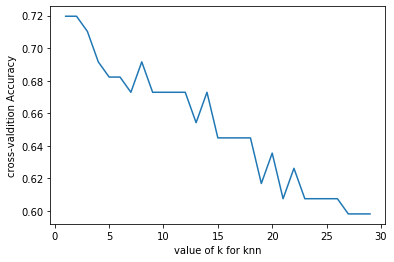

In [97]:
#Highest accuracy by gridSearchCv
K_rang=range(1,30)
K_score=[]
for k in K_rang:
    pipelineTf_Idf = Pipeline([
    ('vectorizer',CountVectorizer(stop_words='english',analyzer='word',ngram_range=(1, 2))),
    ('classifier', KNeighborsClassifier(k))])
    
    model=pipelineTf_Idf.fit(X_train,Y_train)
    y_pred = model.predict(X_test)

    K_score.append(accuracy_score(Y_test, y_pred))
for i in K_score:
    print(i)
    
#plot the value of K for KNN
plt.plot(K_rang,K_score)
plt.xlabel("value of k for knn")
plt.ylabel("cross-valdition Accuracy")

### Exp3- Tf-Idf+ Preprocessed text 


Pipeline(memory=None,
         steps=[('vectorizer',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words='english', strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('classifier',
                 KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                      metric='minkowski', me

[Text(0, 0.5, 'real'), Text(0, 1.5, 'fake')]

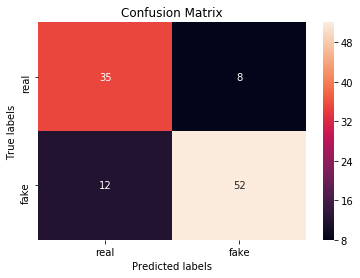

In [98]:
x=df_balanced["strong_pro1"]
y=df_balanced['tag']

tags = []
for tag in y:
    if tag == 'real':
        tags.append(1)
    if tag == 'fake':
        tags.append(0)
y = tags
#print ("tags in binary:", y)

X_train, X_test, Y_train, Y_test = model_selection.train_test_split( x, y, stratify=y, random_state=42,test_size=0.25)

pipeline = Pipeline([
    ('vectorizer',TfidfVectorizer(stop_words='english')),
    ('classifier', KNeighborsClassifier())])


grid = {
    'vectorizer__ngram_range': [(1, 1), (1, 2)],
    'classifier__n_neighbors':range(1,30)
}


grid_search = GridSearchCV(pipeline, param_grid=grid, scoring='accuracy', n_jobs=-1, cv=5)
grid_search.fit(X_train,Y_train)

print(grid_search.best_estimator_,"\n")

best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(list(grid.keys())):
    print("\t{0}: {1}".format(param_name, best_parameters[param_name]))
    

best_model = grid_search.best_estimator_
y_pred=best_model.predict(X_test)

#confusion matrix
confusion=confusion_matrix(Y_test, y_pred)
report=classification_report(Y_test,y_pred)
false_positive_rate, true_positive_rate, thresholds = sk.metrics.roc_curve(Y_test, y_pred)
roc_auc = sk.metrics.auc(false_positive_rate, true_positive_rate)
print("Confusion matrix \n",confusion,"\n")
print("Classification_report \n ",report,"\n")
print("Train Accuracy",accuracy_score(Y_train, best_model.predict(X_train)))
print("Test Accuracy:",accuracy_score(Y_test,y_pred))
print("roc_auc_score",roc_auc)

#confusion matrix plot
ax= plt.subplot()
sns.heatmap(confusion, annot=True, ax = ax)

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('Confusion Matrix') 
ax.xaxis.set_ticklabels(['real', 'fake'])
ax.yaxis.set_ticklabels(['real', 'fake'])

0.7570093457943925
0.7663551401869159
0.7009345794392523
0.6822429906542056
0.7009345794392523
0.7009345794392523
0.6822429906542056
0.6915887850467289
0.6728971962616822
0.6822429906542056
0.6728971962616822
0.6728971962616822
0.6635514018691588
0.6635514018691588
0.6728971962616822
0.6728971962616822
0.6542056074766355
0.6542056074766355
0.6542056074766355
0.6542056074766355
0.6448598130841121
0.6448598130841121
0.6448598130841121
0.6448598130841121
0.6448598130841121
0.6448598130841121
0.6448598130841121
0.6448598130841121
0.6355140186915887


Text(0, 0.5, 'cross-valdition Accuracy')

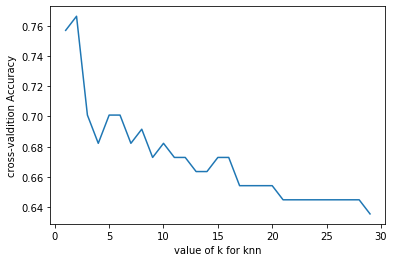

In [99]:
#Highest accuracy by gridSearchCv
K_rang=range(1,30)
K_score=[]
for k in K_rang:
    pipelineTf_Idf = Pipeline([
    ('vectorizer',CountVectorizer(stop_words='english',analyzer='word',ngram_range=(1, 1))),
    ('classifier', KNeighborsClassifier(k))])
    
    model=pipelineTf_Idf.fit(X_train,Y_train)
    y_pred = model .predict(X_test)

    K_score.append(accuracy_score(Y_test, y_pred))
for i in K_score:
    print(i)

#plot the value of K for KNN
plt.plot(K_rang,K_score)
plt.xlabel("value of k for knn")
plt.ylabel("cross-valdition Accuracy")

### Exp4- Tf-Idf + Preprocessed text + Stemming

Pipeline(memory=None,
         steps=[('vectorizer',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words='english', strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('classifier',
                 KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                      metric='minkowski', me

[Text(0, 0.5, 'real'), Text(0, 1.5, 'fake')]

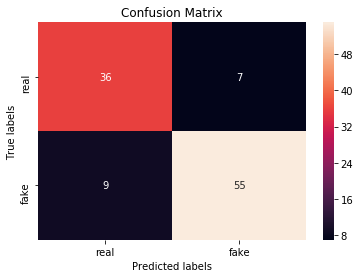

In [100]:
x=df_balanced["Stemming"]
y=df_balanced['tag']

tags = []
for tag in y:
    if tag == 'real':
        tags.append(1)
    if tag == 'fake':
        tags.append(0)
y = tags
#print ("tags in binary:", y)

X_train, X_test, Y_train, Y_test = model_selection.train_test_split( x, y, stratify=y, random_state=42,test_size=0.25)

pipeline = Pipeline([
    ('vectorizer',TfidfVectorizer(stop_words='english')),
    ('classifier', KNeighborsClassifier())])

grid = {
    'vectorizer__ngram_range': [(1, 1), (1, 2)],
    'classifier__n_neighbors':range(1,30)
}

grid_search = GridSearchCV(pipeline, param_grid=grid, scoring='accuracy', n_jobs=-1, cv=5)
grid_search.fit(X_train,Y_train)

print(grid_search.best_estimator_,"\n")

best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(list(grid.keys())):
    print("\t{0}: {1}".format(param_name,  [param_name]))
    

best_model = grid_search.best_estimator_
y_pred=best_model.predict(X_test)

#confusion matrix
confusion=confusion_matrix(Y_test, y_pred)
report=classification_report(Y_test,y_pred)
false_positive_rate, true_positive_rate, thresholds = sk.metrics.roc_curve(Y_test, y_pred)
roc_auc = sk.metrics.auc(false_positive_rate, true_positive_rate)
print("Confusion matrix \n",confusion,"\n")
print("Classification_report \n ",report,"\n")
print("Train Accuracy",accuracy_score(Y_train, best_model.predict(X_train)))
print("Test Accuracy:",accuracy_score(Y_test,y_pred))
print("roc_auc_score",roc_auc)

#confusion matrix plot
ax= plt.subplot()
sns.heatmap(confusion, annot=True, ax = ax)

ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels') 
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['real', 'fake'])
ax.yaxis.set_ticklabels(['real', 'fake'])

0.7570093457943925
0.7570093457943925
0.7102803738317757
0.7009345794392523
0.6822429906542056
0.6728971962616822
0.6915887850467289
0.7009345794392523
0.6728971962616822
0.6728971962616822
0.6728971962616822
0.6728971962616822
0.6728971962616822
0.6728971962616822
0.6728971962616822
0.6728971962616822
0.6635514018691588
0.6635514018691588
0.6542056074766355
0.6635514018691588
0.6542056074766355
0.6728971962616822
0.6635514018691588
0.6728971962616822
0.6542056074766355
0.6542056074766355
0.6542056074766355
0.6635514018691588
0.6448598130841121


Text(0, 0.5, 'cross-valdition Accuracy')

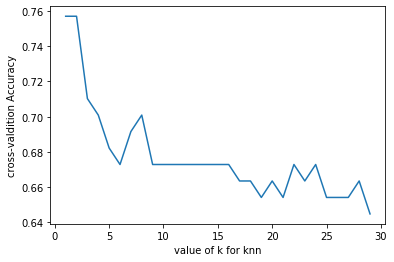

In [101]:
#Highest accuracy by gridSearchCv
K_rang=range(1,30)
K_score=[]
for k in K_rang:
    pipelineTf_Idf = Pipeline([
    ('vectorizer',CountVectorizer(stop_words='english',analyzer='word',ngram_range=(1, 1))),
    ('classifier', KNeighborsClassifier(k))])
    
    model=pipelineTf_Idf.fit(X_train,Y_train)
    y_pred = model.predict(X_test)

    K_score.append(accuracy_score(Y_test, y_pred))
for i in K_score:
    print(i)

#Plot K for KNN
plt.plot(K_rang,K_score)
plt.xlabel("value of k for knn")
plt.ylabel("cross-valdition Accuracy")

# Multinomial Naïve Bayes Classifier

### Exp1: Bow + Preprocessed text

Pipeline(memory=None,
         steps=[('vectorizer',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 2), preprocessor=None,
                                 stop_words='english', strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('classifier',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False) 

	vectorizer__ngram_range: (1, 2)
Confusion matrix 
 [[37  6]
 [10 54]] 

Classification_report 
                precision    recall  f1-score   support

           0       0.79      0.86  

[Text(0, 0.5, 'real'), Text(0, 1.5, 'fake')]

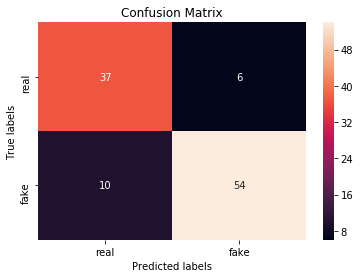

In [102]:
x=df_balanced["strong_pro1"]
y=df_balanced['tag']

tags = []
for tag in y:
    if tag == 'real':
        tags.append(1)
    if tag == 'fake':
        tags.append(0)
y = tags
#print ("tags in binary:", y)

X_train, X_test, Y_train, Y_test = model_selection.train_test_split( x, y, stratify=y, random_state=42,test_size=0.25)

pipeline = Pipeline([
    ('vectorizer',CountVectorizer(stop_words='english')),
    ('classifier', MultinomialNB())])

grid = {
    'vectorizer__ngram_range': [(1, 1), (1, 2)],
}

grid_search = GridSearchCV(pipeline, param_grid=grid, scoring='accuracy', n_jobs=-1, cv=5)
grid_search.fit(X_train,Y_train)

print(grid_search.best_estimator_,"\n")

best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(list(grid.keys())):
    print("\t{0}: {1}".format(param_name, best_parameters[param_name]))

best_model = grid_search.best_estimator_
y_pred=best_model.predict(X_test)

#confusion matrix
confusion=confusion_matrix(Y_test, y_pred)
report=classification_report(Y_test,y_pred)
false_positive_rate, true_positive_rate, thresholds = sk.metrics.roc_curve(Y_test, y_pred)
roc_auc = sk.metrics.auc(false_positive_rate, true_positive_rate)
print("Confusion matrix \n",confusion,"\n")
print("Classification_report \n ",report,"\n")
print("Train Accuracy",accuracy_score(Y_train, best_model.predict(X_train)))
print("Test Accuracy:",accuracy_score(Y_test,y_pred))
print("roc_auc_score",roc_auc)

#confusion matrix plot
ax= plt.subplot()
sns.heatmap(confusion, annot=True, ax = ax)

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix') 
ax.xaxis.set_ticklabels(['real', 'fake'])
ax.yaxis.set_ticklabels(['real', 'fake'])

###  Exp2: Bow + Preprocessed text +Stemming


Pipeline(memory=None,
         steps=[('vectorizer',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words='english', strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('classifier',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False) 

	vectorizer__ngram_range: (1, 1)
Confusion matrix 
 [[38  5]
 [13 51]] 

Classification_report 
                precision    recall  f1-score   support

           0       0.75      0.88  

[Text(0, 0.5, 'real'), Text(0, 1.5, 'fake')]

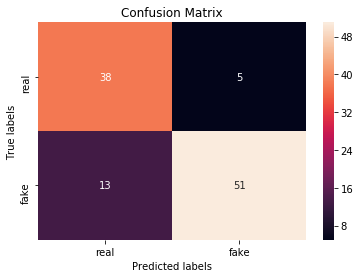

In [103]:
x=df_balanced["Stemming"]
y=df_balanced['tag']

tags = []
for tag in y:
    if tag == 'real':
        tags.append(1)
    if tag == 'fake':
        tags.append(0)
y = tags
#print ("tags in binary:", y)

X_train, X_test, Y_train, Y_test = model_selection.train_test_split( x, y, stratify=y, random_state=42,test_size=0.25)

pipeline = Pipeline([
    ('vectorizer',CountVectorizer(stop_words='english')),
    ('classifier', MultinomialNB())])

grid = {
    'vectorizer__ngram_range': [(1, 1), (1, 2)],
}

grid_search = GridSearchCV(pipeline, param_grid=grid, scoring='accuracy', n_jobs=-1, cv=5)
grid_search.fit(X_train,Y_train)

print(grid_search.best_estimator_,"\n")

best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(list(grid.keys())):
    print("\t{0}: {1}".format(param_name, best_parameters[param_name]))

best_model = grid_search.best_estimator_
y_pred=best_model.predict(X_test)

#confusion matrix
confusion=confusion_matrix(Y_test, y_pred)
report=classification_report(Y_test,y_pred)
false_positive_rate, true_positive_rate, thresholds = sk.metrics.roc_curve(Y_test, y_pred)
roc_auc = sk.metrics.auc(false_positive_rate, true_positive_rate)
print("Confusion matrix \n",confusion,"\n")
print("Classification_report \n ",report,"\n")
print("Train Accuracy",accuracy_score(Y_train, best_model.predict(X_train)))
print("Test Accuracy:",accuracy_score(Y_test,y_pred))
print("roc_auc_score",roc_auc)

#confusion matrix plot
ax= plt.subplot()
sns.heatmap(confusion, annot=True, ax = ax)

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix') 
ax.xaxis.set_ticklabels(['real', 'fake'])
ax.yaxis.set_ticklabels(['real', 'fake'])

### Exp3- Tf-Idf+ Preprocessed text 


Pipeline(memory=None,
         steps=[('vectorizer',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words='english', strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('classifier',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False) 

	vectorizer__ngram_range:

[Text(0, 0.5, 'real'), Text(0, 1.5, 'fake')]

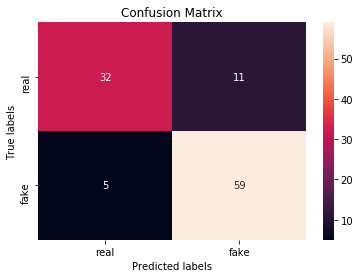

In [104]:
x=df_balanced["strong_pro1"]
y=df_balanced['tag']

tags = []
for tag in y:
    if tag == 'real':
        tags.append(1)
    if tag == 'fake':
        tags.append(0)
y = tags
#print ("tags in binary:", y)

X_train, X_test, Y_train, Y_test = model_selection.train_test_split( x, y, stratify=y, random_state=42,test_size=0.25)

pipeline = Pipeline([
    ('vectorizer',TfidfVectorizer(stop_words='english')),
    ('classifier', MultinomialNB())])

grid = {
    'vectorizer__ngram_range': [(1, 1), (1, 2)],
}
grid_search = GridSearchCV(pipeline, param_grid=grid, scoring='accuracy', n_jobs=-1, cv=5)
grid_search.fit(X_train,Y_train)

print(grid_search.best_estimator_,"\n")

best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(list(grid.keys())):
    print("\t{0}: {1}".format(param_name, best_parameters[param_name]))

best_model = grid_search.best_estimator_
y_pred=best_model.predict(X_test)

#confusion matrix
confusion=confusion_matrix(Y_test, y_pred)
report=classification_report(Y_test,y_pred)
false_positive_rate, true_positive_rate, thresholds = sk.metrics.roc_curve(Y_test, y_pred)
roc_auc = sk.metrics.auc(false_positive_rate, true_positive_rate)
print("Confusion matrix \n",confusion,"\n")
print("Classification_report \n ",report,"\n")
print("Train Accuracy",accuracy_score(Y_train, best_model.predict(X_train)))
print("Test Accuracy:",accuracy_score(Y_test,y_pred))
print("roc_auc_score",roc_auc)

#confusion matrix plot
ax= plt.subplot()
sns.heatmap(confusion, annot=True, ax = ax)

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix') 
ax.xaxis.set_ticklabels(['real', 'fake'])
ax.yaxis.set_ticklabels(['real', 'fake'])

### Exp4- Tf-Idf + Preprocessed text + Stemming

Pipeline(memory=None,
         steps=[('vectorizer',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words='english', strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('classifier',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False) 

	vectorizer__ngram_range:

[Text(0, 0.5, 'real'), Text(0, 1.5, 'fake')]

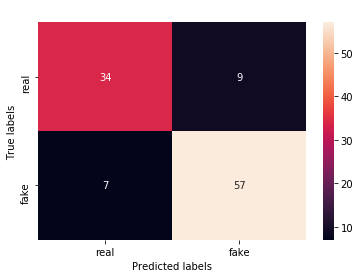

In [105]:
x=df_balanced["Stemming"]
y=df_balanced['tag']

tags = []
for tag in y:
    if tag == 'real':
        tags.append(1)
    if tag == 'fake':
        tags.append(0)
y = tags
#print ("tags in binary:", y)

X_train, X_test, Y_train, Y_test = model_selection.train_test_split( x, y, stratify=y, random_state=42,test_size=0.25)

pipeline = Pipeline([
    ('vectorizer',TfidfVectorizer(stop_words='english')),
    ('classifier', MultinomialNB())])


grid = {
    'vectorizer__ngram_range': [(1, 1), (1, 2)],
}
grid_search = GridSearchCV(pipeline, param_grid=grid, scoring='accuracy', n_jobs=-1, cv=5)
grid_search.fit(X_train,Y_train)

print(grid_search.best_estimator_,"\n")

best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(list(grid.keys())):
    print("\t{0}: {1}".format(param_name, best_parameters[param_name]))

best_model = grid_search.best_estimator_
y_pred=best_model.predict(X_test)

#confusion matrix
confusion=confusion_matrix(Y_test, y_pred)
report=classification_report(Y_test,y_pred)
false_positive_rate, true_positive_rate, thresholds = sk.metrics.roc_curve(Y_test, y_pred)
roc_auc = sk.metrics.auc(false_positive_rate, true_positive_rate)
print("Confusion matrix \n",confusion,"\n")
print("Classification_report \n ",report,"\n")
print("Train Accuracy",accuracy_score(Y_train, best_model.predict(X_train)))
print("Test Accuracy:",accuracy_score(Y_test,y_pred))
print("roc_auc_score",roc_auc)

#confusion matrix plot
ax= plt.subplot()
sns.heatmap(confusion, annot=True, ax = ax)

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title(' ')
ax.xaxis.set_ticklabels(['real', 'fake'])
ax.yaxis.set_ticklabels(['real', 'fake'])

# Support Vector Machine Classifier 

### Exp1: Bow + Preprocessed text

Pipeline(memory=None,
         steps=[('vectorizer',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words='english', strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('classifier',
                 SVC(C=0.1, cache_size=200, class_weight=None, coef0=0.0,
                     decision_function_shape='ovr', degree=3,
                     gamma='auto_deprecated', kernel='linear', max_iter=-1,
                     probability=False, random_state=None, shrinking=True,
      

[Text(0, 0.5, 'real'), Text(0, 1.5, 'fake')]

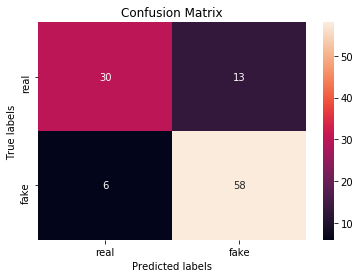

In [106]:
x=df_balanced["strong_pro1"]
y=df_balanced['tag']

tags = []
for tag in y:
    if tag == 'real':
        tags.append(1)
    if tag == 'fake':
        tags.append(0)
y = tags
#print ("tags in binary:", y)

X_train, X_test, Y_train, Y_test = model_selection.train_test_split( x, y, stratify=y, random_state=42,test_size=0.25)

pipeline = Pipeline([
    ('vectorizer',CountVectorizer(stop_words='english')),
    ('classifier', SVC(kernel='linear'))])

grid = {
    'vectorizer__ngram_range': [(1, 1), (1, 2)],
    'classifier__C':[0.01,0.1,1,10]
}

grid_search = GridSearchCV(pipeline, param_grid=grid, scoring='accuracy', n_jobs=-1, cv=5)
grid_search.fit(X_train,Y_train)

print(grid_search.best_estimator_,"\n")

best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(list(grid.keys())):
    print("\t{0}: {1}".format(param_name, best_parameters[param_name]))

best_model = grid_search.best_estimator_
y_pred=best_model.predict(X_test)

#confusion matrix
confusion=confusion_matrix(Y_test, y_pred)
report=classification_report(Y_test,y_pred)
false_positive_rate, true_positive_rate, thresholds = sk.metrics.roc_curve(Y_test, y_pred)
roc_auc = sk.metrics.auc(false_positive_rate, true_positive_rate)
print("Confusion matrix \n",confusion,"\n")
print("Classification_report \n ",report,"\n")
print("Train Accuracy",accuracy_score(Y_train, best_model.predict(X_train)))
print("Test Accuracy:",accuracy_score(Y_test,y_pred))
print("roc_auc_score",roc_auc)

#confusion matrix plot
ax= plt.subplot()
sns.heatmap(confusion, annot=True, ax = ax)

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix') 
ax.xaxis.set_ticklabels(['real', 'fake']) 
ax.yaxis.set_ticklabels(['real', 'fake'])

### Exp2: Bow + Preprocessed text +Stemming


Pipeline(memory=None,
         steps=[('vectorizer',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words='english', strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('classifier',
                 SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
                     decision_function_shape='ovr', degree=3,
                     gamma='auto_deprecated', kernel='linear', max_iter=-1,
                     probability=False, random_state=None, shrinking=True,
        

[Text(0, 0.5, 'real'), Text(0, 1.5, 'fake')]

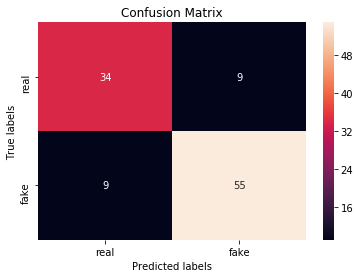

In [107]:
x=df_balanced["Stemming"]
y=df_balanced['tag']

tags = []
for tag in y:
    if tag == 'real':
        tags.append(1)
    if tag == 'fake':
        tags.append(0)
y = tags
#print ("tags in binary:", y)


X_train, X_test, Y_train, Y_test = model_selection.train_test_split( x, y, stratify=y, random_state=42,test_size=0.25)

pipeline = Pipeline([
    ('vectorizer',CountVectorizer(stop_words='english')),
    ('classifier', SVC(kernel='linear'))])

grid = {
    'vectorizer__ngram_range': [(1, 1), (1, 2)],
    'classifier__C':[0.01,0.1,1,10]
}


grid_search = GridSearchCV(pipeline, param_grid=grid, scoring='accuracy', n_jobs=-1, cv=5)
grid_search.fit(X_train,Y_train)

print(grid_search.best_estimator_,"\n")

best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(list(grid.keys())):
    print("\t{0}: {1}".format(param_name, best_parameters[param_name]))

best_model = grid_search.best_estimator_
y_pred=best_model.predict(X_test)

#confusion matrix
confusion=confusion_matrix(Y_test, y_pred)
report=classification_report(Y_test,y_pred)
false_positive_rate, true_positive_rate, thresholds = sk.metrics.roc_curve(Y_test, y_pred)
roc_auc = sk.metrics.auc(false_positive_rate, true_positive_rate)
print("Confusion matrix \n",confusion,"\n")
print("Classification_report \n ",report,"\n")
print("Train Accuracy",accuracy_score(Y_train, best_model.predict(X_train)))
print("Test Accuracy:",accuracy_score(Y_test,y_pred))
print("roc_auc_score",roc_auc)

#confusion matrix plot
ax= plt.subplot()
sns.heatmap(confusion, annot=True, ax = ax)

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['real', 'fake'])
ax.yaxis.set_ticklabels(['real', 'fake'])

### Exp3- Tf-Idf+ Preprocessed text 


Pipeline(memory=None,
         steps=[('vectorizer',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 2), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words='english', strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('classifier',
                 SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
                     decision_function_shape='ovr', degre

[Text(0, 0.5, 'real'), Text(0, 1.5, 'fake')]

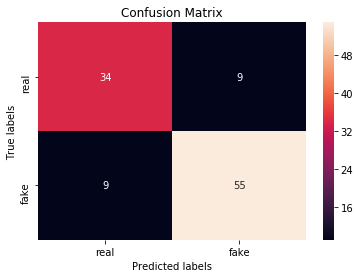

In [108]:
x=df_balanced["strong_pro1"]
y=df_balanced['tag']

tags = []
for tag in y:
    if tag == 'real':
        tags.append(1)
    if tag == 'fake':
        tags.append(0)
y = tags
#print ("tags in binary:", y)


X_train, X_test, Y_train, Y_test = model_selection.train_test_split( x, y, stratify=y, random_state=42,test_size=0.25)

pipeline = Pipeline([
    ('vectorizer',TfidfVectorizer(stop_words='english')),
    ('classifier', SVC(kernel='linear'))])

grid = {
    'vectorizer__ngram_range': [(1, 1), (1, 2)],
    'classifier__C':[0.01,0.1,1,10]
}
grid_search = GridSearchCV(pipeline, param_grid=grid, scoring='accuracy', n_jobs=-1, cv=5)
grid_search.fit(X_train,Y_train)

print(grid_search.best_estimator_,"\n")

best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(list(grid.keys())):
    print("\t{0}: {1}".format(param_name, best_parameters[param_name]))

best_model = grid_search.best_estimator_
y_pred=best_model.predict(X_test)

#confusion matrix
confusion=confusion_matrix(Y_test, y_pred)
report=classification_report(Y_test,y_pred)
false_positive_rate, true_positive_rate, thresholds = sk.metrics.roc_curve(Y_test, y_pred)
roc_auc = sk.metrics.auc(false_positive_rate, true_positive_rate)
print("Confusion matrix \n",confusion,"\n")
print("Classification_report \n ",report,"\n")
print("Train Accuracy",accuracy_score(Y_train, best_model.predict(X_train)))
print("Test Accuracy:",accuracy_score(Y_test,y_pred))
print("roc_auc_score",roc_auc)

#confusion matrix plot
ax= plt.subplot()
sns.heatmap(confusion, annot=True, ax = ax)

ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels') 
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['real', 'fake'])
ax.yaxis.set_ticklabels(['real', 'fake'])

### Exp4- Tf-Idf + Preprocessed text + Stemming

Pipeline(memory=None,
         steps=[('vectorizer',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 2), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words='english', strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('classifier',
                 SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
                     decision_function_shape='ovr', degre

[Text(0, 0.5, 'real'), Text(0, 1.5, 'fake')]

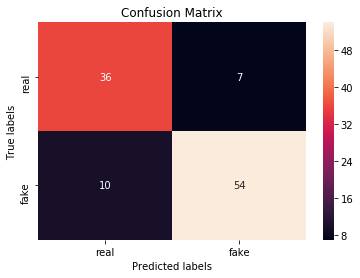

In [109]:
x=df_balanced["Stemming"]
y=df_balanced['tag']

tags = []
for tag in y:
    if tag == 'real':
        tags.append(1)
    if tag == 'fake':
        tags.append(0)
y = tags
#print ("tags in binary:", y)


X_train, X_test, Y_train, Y_test = model_selection.train_test_split( x, y, stratify=y, random_state=42,test_size=0.25)

pipeline = Pipeline([
    ('vectorizer',TfidfVectorizer(stop_words='english')),
    ('classifier', SVC(kernel='linear'))])

grid = {
    'vectorizer__ngram_range': [(1, 1), (1, 2)],
    'classifier__C':[0.01,0.1,1,10]
}
grid_search = GridSearchCV(pipeline, param_grid=grid, scoring='accuracy', n_jobs=-1, cv=5)
grid_search.fit(X_train,Y_train)

print(grid_search.best_estimator_,"\n")

best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(list(grid.keys())):
    print("\t{0}: {1}".format(param_name, best_parameters[param_name]))

best_model = grid_search.best_estimator_
y_pred=best_model.predict(X_test)

#confusion matrix
confusion=confusion_matrix(Y_test, y_pred)
report=classification_report(Y_test,y_pred)
false_positive_rate, true_positive_rate, thresholds = sk.metrics.roc_curve(Y_test, y_pred)
roc_auc = sk.metrics.auc(false_positive_rate, true_positive_rate)
print("Confusion matrix \n",confusion,"\n")
print("Classification_report \n ",report,"\n")
print("Train Accuracy",accuracy_score(Y_train, best_model.predict(X_train)))
print("Test Accuracy:",accuracy_score(Y_test,y_pred))
print("roc_auc_score",roc_auc)

#confusion matrix plot
ax= plt.subplot()
sns.heatmap(confusion, annot=True, ax = ax)

ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels') 
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['real', 'fake'])
ax.yaxis.set_ticklabels(['real', 'fake'])

# Decision Tree Classifier


### Exp1: Bow + Preprocessed text

Pipeline(memory=None,
         steps=[('vectorizer',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words='english', strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('classifier',
                 DecisionTreeClassifier(class_weight=None, criterion='gini',
                                        max_depth=9, max_features=None,
                                        max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                

[Text(0, 0.5, 'real'), Text(0, 1.5, 'fake')]

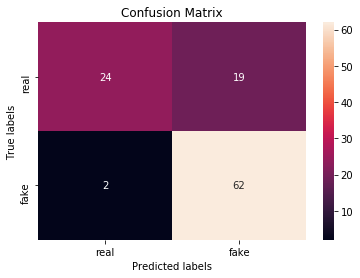

In [110]:
x=df_balanced["strong_pro1"]
y=df_balanced['tag']

tags = []
for tag in y:
    if tag == 'real':
        tags.append(1)
    if tag == 'fake':
        tags.append(0)
y = tags
#print ("tags in binary:", y)


X_train, X_test, Y_train, Y_test = model_selection.train_test_split( x, y, stratify=y, random_state=42,test_size=0.25)

pipeline = Pipeline([
    ('vectorizer',CountVectorizer(stop_words='english')),
    ('classifier', DecisionTreeClassifier(random_state=42,max_depth=9))])

grid = {
    'vectorizer__ngram_range': [(1, 1), (1, 2)],
}


grid_search = GridSearchCV(pipeline, param_grid=grid, scoring='accuracy', n_jobs=-1, cv=5)
grid_search.fit(X_train,Y_train)

print(grid_search.best_estimator_,"\n")

best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(list(grid.keys())):
    print("\t{0}: {1}".format(param_name, best_parameters[param_name]))

best_model = grid_search.best_estimator_
y_pred=best_model.predict(X_test)

#confusion matrix
confusion=confusion_matrix(Y_test, y_pred)
report=classification_report(Y_test,y_pred)
false_positive_rate, true_positive_rate, thresholds = sk.metrics.roc_curve(Y_test, y_pred)
roc_auc = sk.metrics.auc(false_positive_rate, true_positive_rate)
print("Confusion matrix \n",confusion,"\n")
print("Classification_report \n ",report,"\n")
print("Train Accuracy",accuracy_score(Y_train, best_model.predict(X_train)))
print("Test Accuracy:",accuracy_score(Y_test,y_pred))
print("roc_auc_score",roc_auc)

#confusion matrix plot
ax= plt.subplot()
sns.heatmap(confusion, annot=True, ax = ax)

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['real', 'fake'])
ax.yaxis.set_ticklabels(['real', 'fake'])

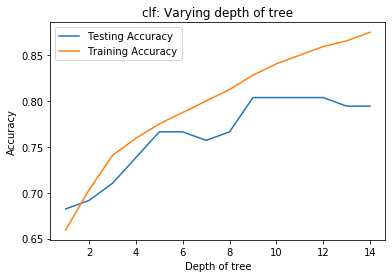

In [111]:
x=df_balanced["strong_pro1"]
y=df_balanced['tag']

X_train, X_test, Y_train, Y_test = model_selection.train_test_split( x, y, stratify=y, random_state=42,test_size=0.25)

BoW=CountVectorizer(stop_words='english')
X_train=BoW.fit_transform(X_train)
X_test= BoW.transform(X_test)

# Setup arrays to store train and test accuracies
dep = np.arange(1, 15)
train_accuracy = np.empty(len(dep))
test_accuracy = np.empty(len(dep))

# Decision Tree Classifier and fit it to training data
for i, k in enumerate(dep):
    clf = sk.tree.DecisionTreeClassifier(random_state=42,max_depth=k)
    clf.fit(X_train, Y_train)
    train_accuracy[i] = clf.score(X_train, Y_train)
    test_accuracy[i] = clf.score(X_test, Y_test)

# Generate plot
plt.title('clf: Varying depth of tree')
plt.plot(dep, test_accuracy, label = 'Testing Accuracy')
plt.plot(dep, train_accuracy, label = 'Training Accuracy')
plt.legend()
plt.xlabel('Depth of tree')
plt.ylabel('Accuracy')
plt.show()

### Exp2: Bow + Preprocessed text +Stemming


Pipeline(memory=None,
         steps=[('vectorizer',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 2), preprocessor=None,
                                 stop_words='english', strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('classifier',
                 DecisionTreeClassifier(class_weight=None, criterion='gini',
                                        max_depth=6, max_features=None,
                                        max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                

[Text(0, 0.5, 'real'), Text(0, 1.5, 'fake')]

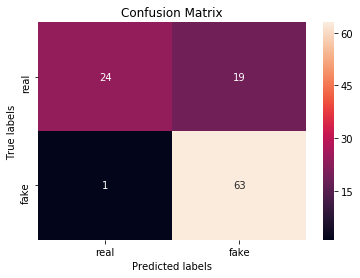

In [112]:
x=df_balanced["Stemming"]
y=df_balanced['tag']

tags = []
for tag in y:
    if tag == 'real':
        tags.append(1)
    if tag == 'fake':
        tags.append(0)
y = tags
#print ("tags in binary:", y)


X_train, X_test, Y_train, Y_test = model_selection.train_test_split( x, y, stratify=y, random_state=42,test_size=0.25)

pipeline = Pipeline([
    ('vectorizer',CountVectorizer(stop_words='english')),
    ('classifier', DecisionTreeClassifier(random_state=42,max_depth=6))])

grid = {
    'vectorizer__ngram_range': [(1, 1), (1, 2)],
}
grid_search = GridSearchCV(pipeline, param_grid=grid, scoring='accuracy', n_jobs=-1, cv=5)
grid_search.fit(X_train,Y_train)

print(grid_search.best_estimator_,"\n")

best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(list(grid.keys())):
    print("\t{0}: {1}".format(param_name, best_parameters[param_name]))

#confusion matrix
best_model = grid_search.best_estimator_
y_pred=best_model.predict(X_test)

confusion=confusion_matrix(Y_test, y_pred)
report=classification_report(Y_test,y_pred)
false_positive_rate, true_positive_rate, thresholds = sk.metrics.roc_curve(Y_test, y_pred)
roc_auc = sk.metrics.auc(false_positive_rate, true_positive_rate)
print("Confusion matrix \n",confusion,"\n")
print("Classification_report \n ",report,"\n")
print("Train Accuracy",accuracy_score(Y_train, best_model.predict(X_train)))
print("Test Accuracy:",accuracy_score(Y_test,y_pred))
print("roc_auc_score",roc_auc)

#confusion matrix plot
ax= plt.subplot()
sns.heatmap(confusion, annot=True, ax = ax)

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['real', 'fake'])
ax.yaxis.set_ticklabels(['real', 'fake'])

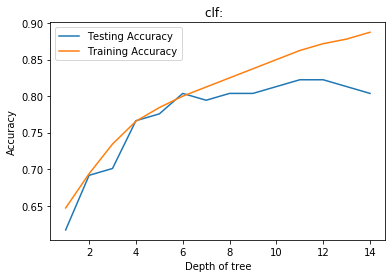

In [113]:
x=df_balanced["Stemming"]
y=df_balanced['tag']

X_train, X_test, Y_train, Y_test = model_selection.train_test_split( x, y, stratify=y, random_state=42,test_size=0.25)

BoW=CountVectorizer(stop_words='english')
X_train=BoW.fit_transform(X_train)
X_test= BoW.transform(X_test)

dep = np.arange(1, 15)
train_accuracy = np.empty(len(dep))
test_accuracy = np.empty(len(dep))

# Decision Tree Classifier and fit training data
for i, k in enumerate(dep):
    clf = sk.tree.DecisionTreeClassifier(random_state=42,max_depth=k)
    clf.fit(X_train, Y_train)
    train_accuracy[i] = clf.score(X_train, Y_train)
    test_accuracy[i] = clf.score(X_test, Y_test)

# Generate plot
plt.title('clf:  ')
plt.plot(dep, test_accuracy, label = 'Testing Accuracy')
plt.plot(dep, train_accuracy, label = 'Training Accuracy')
plt.legend()
plt.xlabel('Depth of tree')
plt.ylabel('Accuracy')
plt.show()

### Exp3- Tf-Idf+ Preprocessed text 


Pipeline(memory=None,
         steps=[('vectorizer',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 2), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words='english', strip_accents=None,
                                 sublinear_tf=False,
                                 token...,
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('classifier',
                 DecisionTreeClassifier(class_weight=None, criterion='gini',
                                        max_depth=9, max_features=None,
      

[Text(0, 0.5, 'real'), Text(0, 1.5, 'fake')]

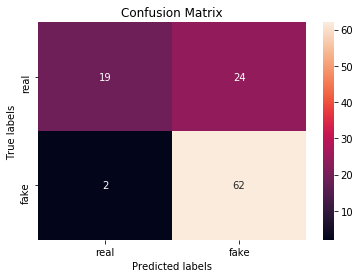

In [114]:
x=df_balanced["strong_pro1"]
y=df_balanced['tag']

tags = []
for tag in y:
    if tag == 'real':
        tags.append(1)
    if tag == 'fake':
        tags.append(0)
y = tags
#print ("tags in binary:", y)

X_train, X_test, Y_train, Y_test = model_selection.train_test_split( x, y, stratify=y, random_state=42,test_size=0.25)

pipeline = Pipeline([
    ('vectorizer',TfidfVectorizer(stop_words='english')),
    ('classifier', DecisionTreeClassifier(random_state=42,max_depth=9))])

grid = {
    'vectorizer__ngram_range': [(1, 1), (1, 2)],
}

grid_search = GridSearchCV(pipeline, param_grid=grid, scoring='accuracy', n_jobs=-1, cv=5)
grid_search.fit(X_train,Y_train)

print(grid_search.best_estimator_,"\n")

best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(list(grid.keys())):
    print("\t{0}: {1}".format(param_name, best_parameters[param_name]))

#confusion matrix
best_model = grid_search.best_estimator_
y_pred=best_model.predict(X_test)

confusion=confusion_matrix(Y_test, y_pred)
report=classification_report(Y_test,y_pred)
false_positive_rate, true_positive_rate, thresholds = sk.metrics.roc_curve(Y_test, y_pred)
roc_auc = sk.metrics.auc(false_positive_rate, true_positive_rate)
print("Confusion matrix \n",confusion,"\n")
print("Classification_report \n ",report,"\n")
print("Train Accuracy",accuracy_score(Y_train, best_model.predict(X_train)))
print("Test Accuracy:",accuracy_score(Y_test,y_pred))
print("roc_auc_score",roc_auc)

#confusion matrix plot
ax= plt.subplot()
sns.heatmap(confusion, annot=True, ax = ax)

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['real', 'fake'])
ax.yaxis.set_ticklabels(['real', 'fake'])

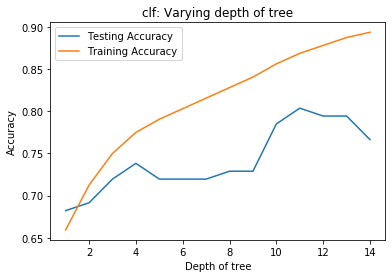

In [115]:
x=df_balanced["strong_pro1"]
y=df_balanced['tag']

X_train, X_test, Y_train, Y_test = model_selection.train_test_split( x, y, stratify=y, random_state=42,test_size=0.25)

BoW=TfidfVectorizer(stop_words='english')
X_train=BoW.fit_transform(X_train)
X_test= BoW.transform(X_test)

dep = np.arange(1, 15)
train_accuracy = np.empty(len(dep))
test_accuracy = np.empty(len(dep))

# Decision Tree Classifier adn fit it to training
for i, k in enumerate(dep):
    clf = sk.tree.DecisionTreeClassifier(random_state=42,max_depth=k)
    clf.fit(X_train, Y_train)
    train_accuracy[i] = clf.score(X_train, Y_train)
    test_accuracy[i] = clf.score(X_test, Y_test)

# Generate plot
plt.title('clf: Varying depth of tree')
plt.plot(dep, test_accuracy, label = 'Testing Accuracy')
plt.plot(dep, train_accuracy, label = 'Training Accuracy')
plt.legend()
plt.xlabel('Depth of tree')
plt.ylabel('Accuracy')
plt.show()

### Exp4- Tf-Idf + Preprocessed text + Stemming 

Pipeline(memory=None,
         steps=[('vectorizer',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words='english', strip_accents=None,
                                 sublinear_tf=False,
                                 token...,
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('classifier',
                 DecisionTreeClassifier(class_weight=None, criterion='gini',
                                        max_depth=5, max_features=None,
      

[Text(0, 0.5, 'real'), Text(0, 1.5, 'fake')]

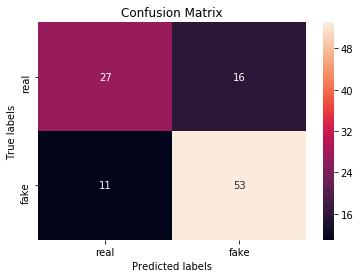

In [116]:
x=df_balanced["Stemming"]
y=df_balanced['tag']

tags = []
for tag in y:
    if tag == 'real':
        tags.append(1)
    if tag == 'fake':
        tags.append(0)
y = tags
#print ("tags in binary:", y)

X_train, X_test, Y_train, Y_test = model_selection.train_test_split( x, y, stratify=y, random_state=42,test_size=0.25)

pipeline = Pipeline([
    ('vectorizer',TfidfVectorizer(stop_words='english')),
    ('classifier', DecisionTreeClassifier(random_state=42,max_depth= 5))])

grid = {
    'vectorizer__ngram_range': [(1, 1), (1, 2)],
}

grid_search = GridSearchCV(pipeline, param_grid=grid, scoring='accuracy', n_jobs=-1, cv=5)
grid_search.fit(X_train,Y_train)

print(grid_search.best_estimator_,"\n")

best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(list(grid.keys())):
    print("\t{0}: {1}".format(param_name, best_parameters[param_name]))

#confusion matrix
best_model = grid_search.best_estimator_
y_pred=best_model.predict(X_test)

confusion=confusion_matrix(Y_test, y_pred)
report=classification_report(Y_test,y_pred)
false_positive_rate, true_positive_rate, thresholds = sk.metrics.roc_curve(Y_test, y_pred)
roc_auc = sk.metrics.auc(false_positive_rate, true_positive_rate)
print("Confusion matrix \n",confusion,"\n")
print("Classification_report \n ",report,"\n")
print("Train Accuracy",accuracy_score(Y_train, best_model.predict(X_train)))
print("Test Accuracy:",accuracy_score(Y_test,y_pred))
print("roc_auc_score",roc_auc)

#confusion matrix plot
ax= plt.subplot()
sns.heatmap(confusion, annot=True, ax = ax)

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['real', 'fake'])
ax.yaxis.set_ticklabels(['real', 'fake'])

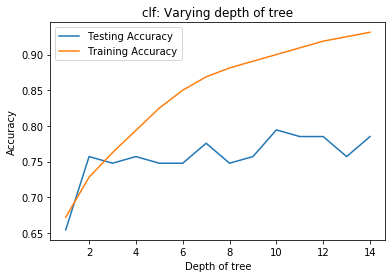

In [117]:
x=df_balanced["Stemming"]
y=df_balanced['tag']

X_train, X_test, Y_train, Y_test = model_selection.train_test_split( x, y, stratify=y, random_state=42,test_size=0.25)

BoW=TfidfVectorizer(stop_words='english')
X_train=BoW.fit_transform(X_train)
X_test= BoW.transform(X_test)

dep = np.arange(1, 15)
train_accuracy = np.empty(len(dep))
test_accuracy = np.empty(len(dep))

# Decision Tree Classifier adn fit it to traiing data
for i, k in enumerate(dep):
    clf = sk.tree.DecisionTreeClassifier(random_state=42,max_depth=k)
    clf.fit(X_train, Y_train)
    train_accuracy[i] = clf.score(X_train, Y_train)
    test_accuracy[i] = clf.score(X_test, Y_test)

# Generate Varying depth tree
plt.title('clf: Varying depth of tree')
plt.plot(dep, test_accuracy, label = 'Testing Accuracy')
plt.plot(dep, train_accuracy, label = 'Training Accuracy')
plt.legend()
plt.xlabel('Depth of tree')
plt.ylabel('Accuracy')
plt.show()